In [18]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from utils import extract_H_T, read_train_val_test_loss
from constants import DATASETS

In [24]:
def analyse(exp_dir: str ='exp', model: str ='dlinear'):

    all_data_train_mse = []
    all_data_val_mse = []
    all_data_test_mse = []

    for data in DATASETS:
        data_dir = os.path.join(exp_dir, model, data)

        h = []
        t = []
        val_mse = []
        train_mse = []
        test_mse = []

        for ht_dir_name in os.listdir(data_dir):
            ht_dir_path = os.path.join(data_dir, ht_dir_name)
            H,T = extract_H_T(ht_dir_name)

            train_losses, val_losses, test_loss = read_train_val_test_loss(ht_dir_path)

            h.append(H)
            t.append(T)
            val_mse.append(min(val_losses))
            train_mse.append(min(train_losses))
            test_mse.append(test_loss)

        all_data_train_mse.append(train_mse)
        all_data_val_mse.append(val_mse)
        all_data_test_mse.append(test_mse)

        df = pd.DataFrame({
            'H': h,
            'T': t,
            'train_mse': train_mse,
            'val_mse': val_mse,
            'test_mse': test_mse
        })

        # sns.scatterplot(df, x='H', y='T', size='val_mse', sizes=(20,200), legend=False)
        # plt.title(f'model:{model}, data:{data}')
        # plt.show()

        df.sort_values(by='T')

        for mse_col in ['train_mse', 'val_mse', 'test_mse']:
            sns.catplot(df, x='T', y=mse_col, hue='H', kind='bar', palette='rocket', height=5, aspect=3)
            plt.title(f'{model}, {data} - {mse_col[:-4]}')
            plt.show()

        print('*'*50)
            
    def cal_mean_of_datasets_by_same_config(all_mse_list: List[List[float]]):
        return list(map(np.mean, list(zip(*all_mse_list))))

    mean_train_mse = cal_mean_of_datasets_by_same_config(all_data_train_mse)
    mean_val_mse = cal_mean_of_datasets_by_same_config(all_data_val_mse)
    mean_test_mse = cal_mean_of_datasets_by_same_config(all_data_test_mse)

    df = pd.DataFrame({
        'H': h,
        'T': t,
        'train_mse': mean_train_mse,
        'val_mse': mean_val_mse,
        'test_mse': mean_test_mse
    })

    sns.catplot(df, x='T', y='test_mse', hue='H', kind='bar', palette='rocket', height=5, aspect=3)
    plt.title(f'{model}, mean of mse(s) of test datasets')
    plt.show()


In [19]:
x = [1,2,3]
y = [4,5,6]
z = [7,8,9]
arr = [x,y,z]
list(zip(x,y,z))


[(1, 4, 7), (2, 5, 8), (3, 6, 9)]

In [20]:
list(zip(*arr))

[(1, 4, 7), (2, 5, 8), (3, 6, 9)]

In [17]:
list(map(np.mean, list(zip(x,y,z))))

[4.0, 5.0, 6.0]

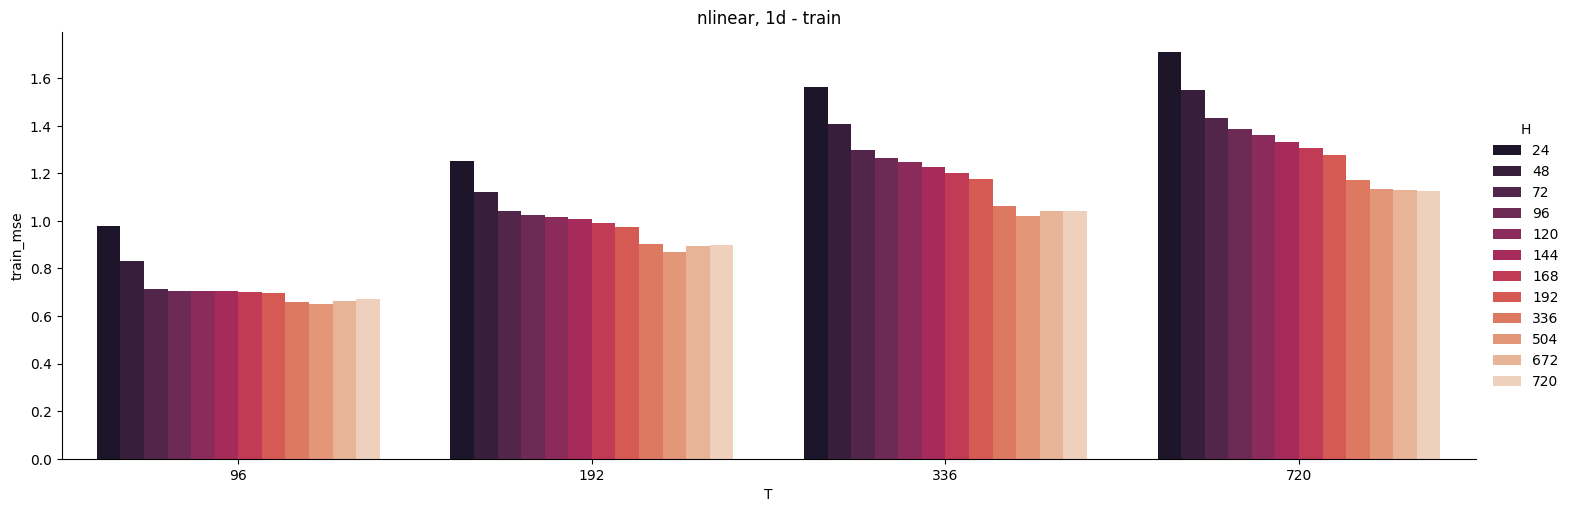

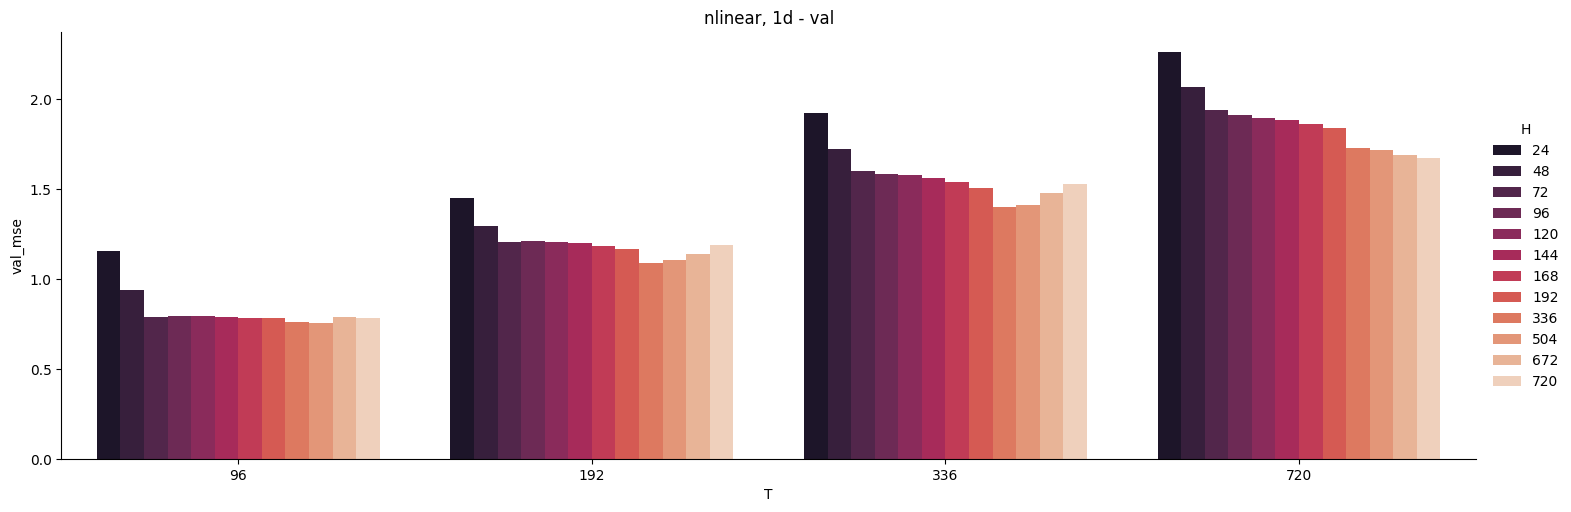

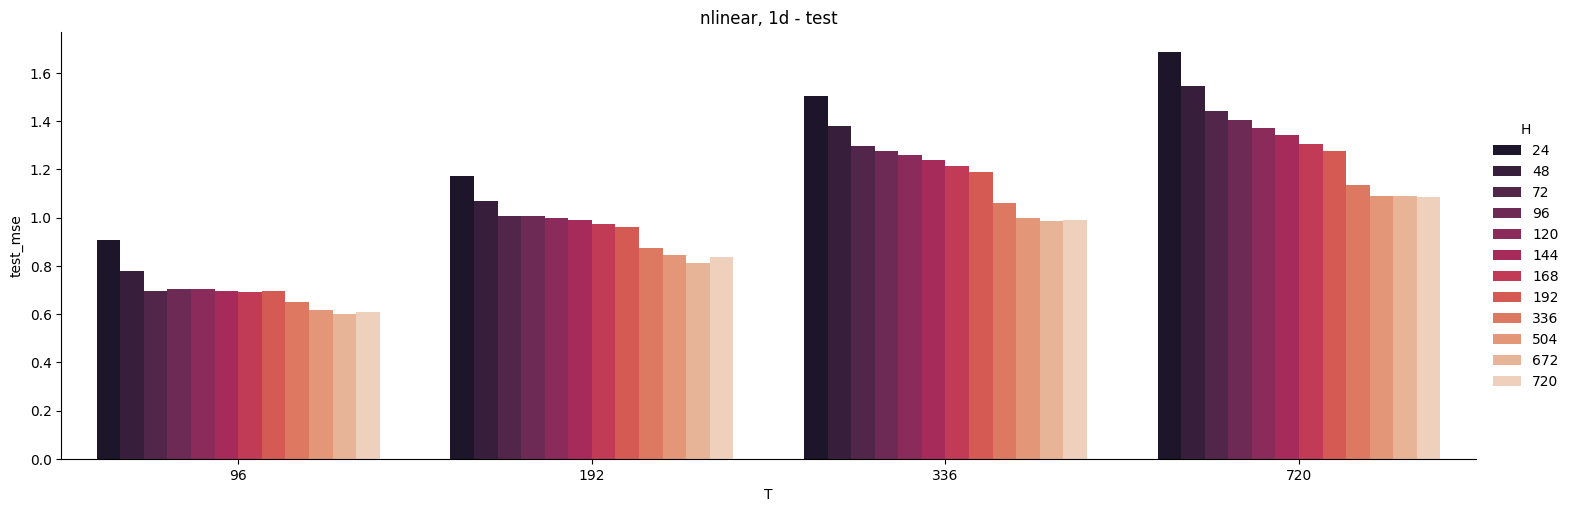

**************************************************


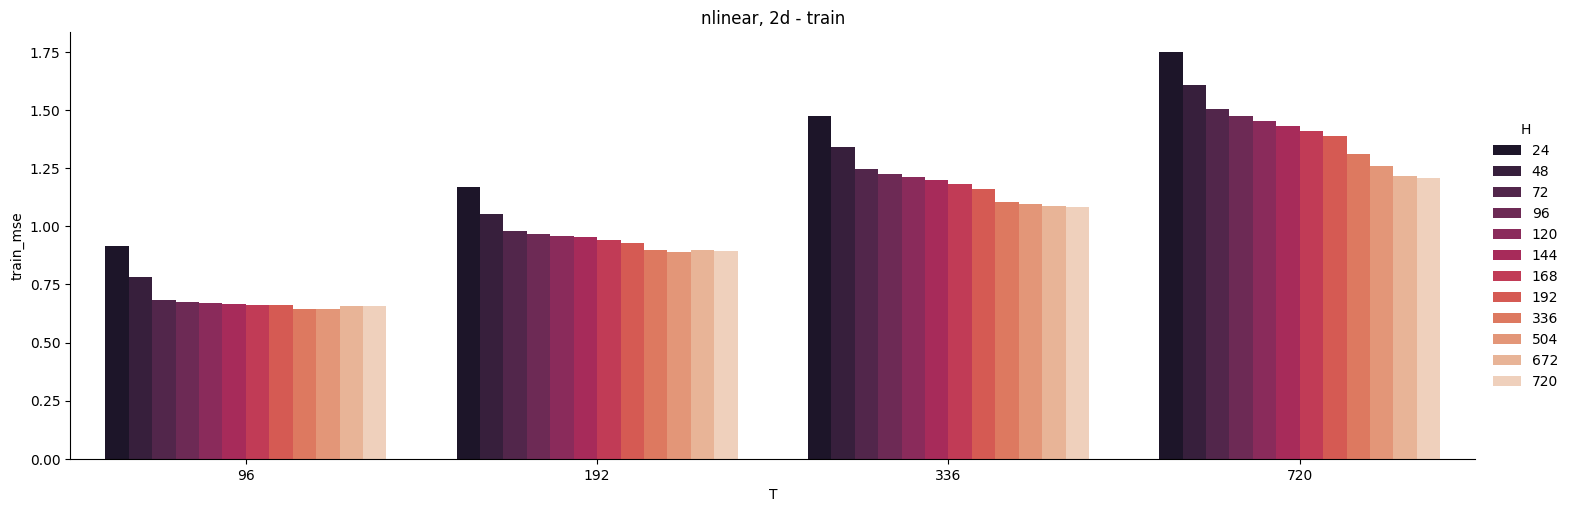

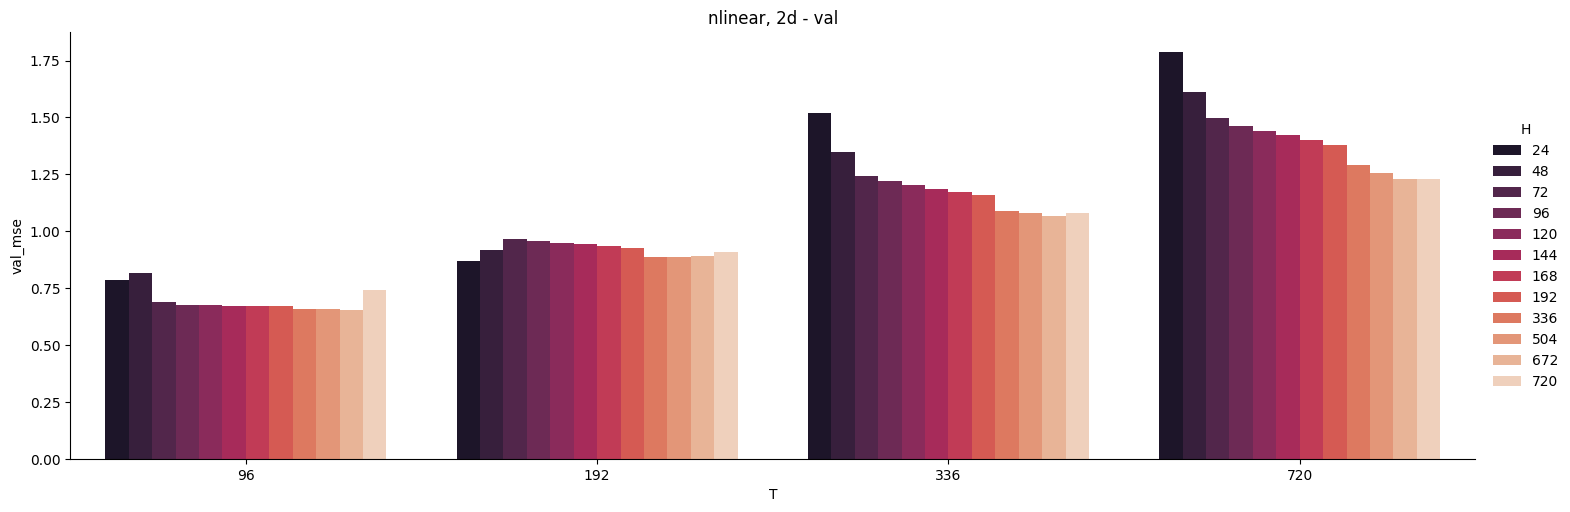

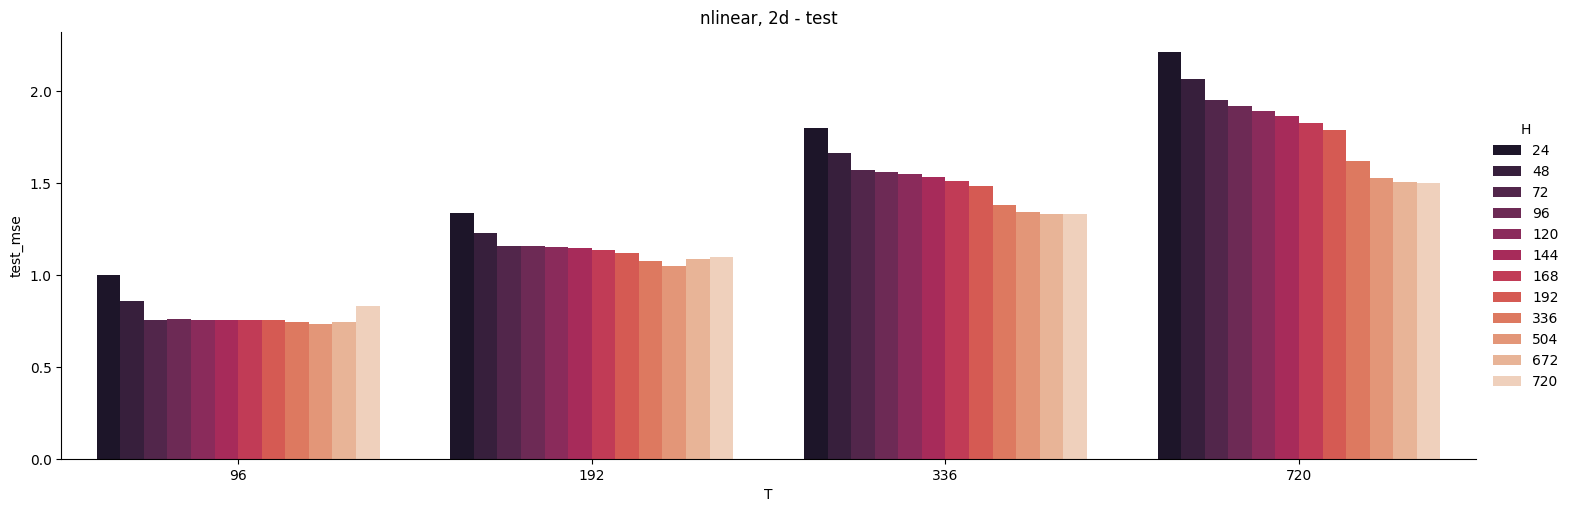

**************************************************


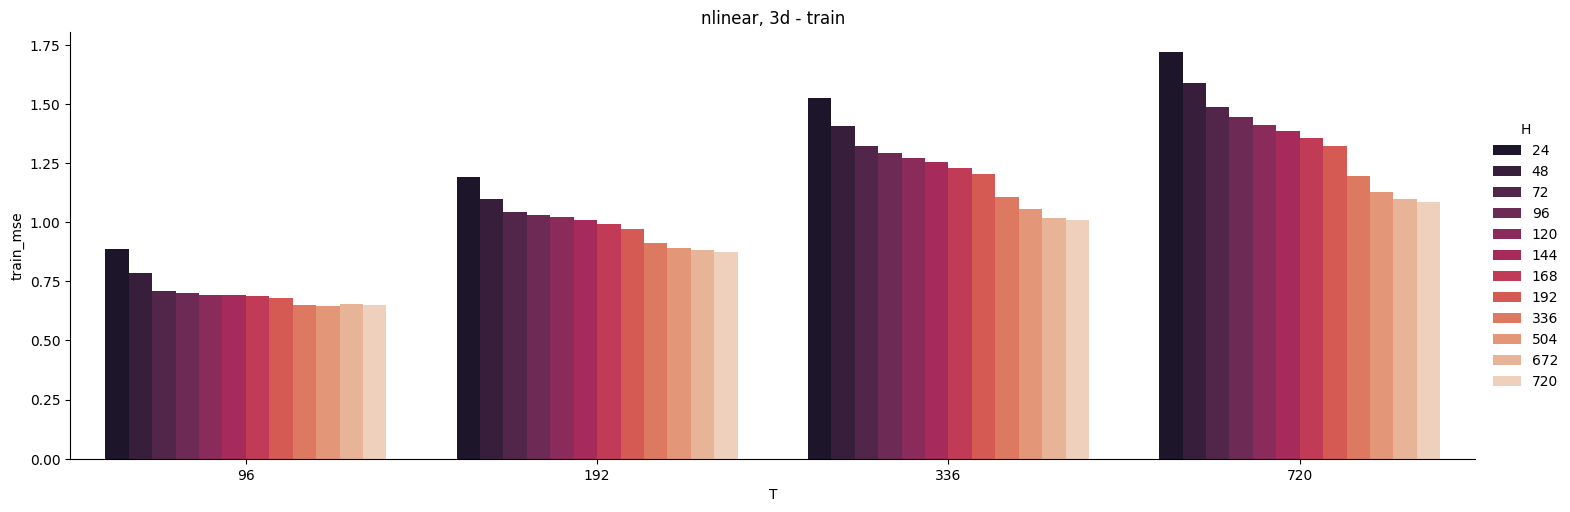

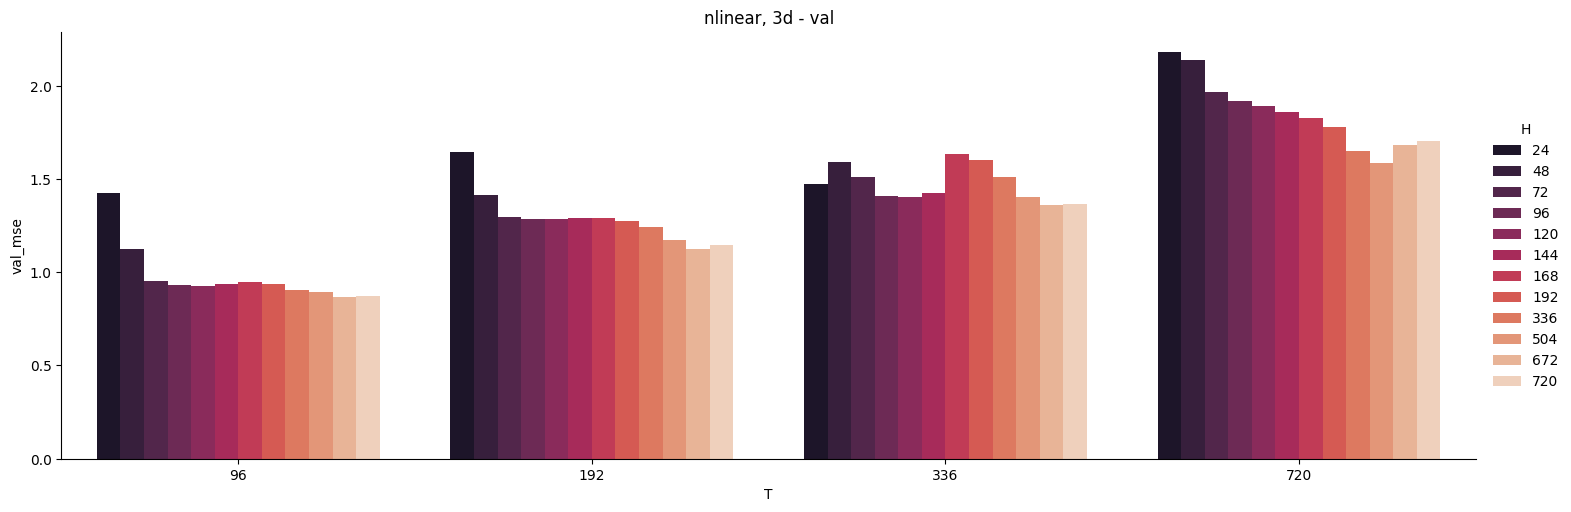

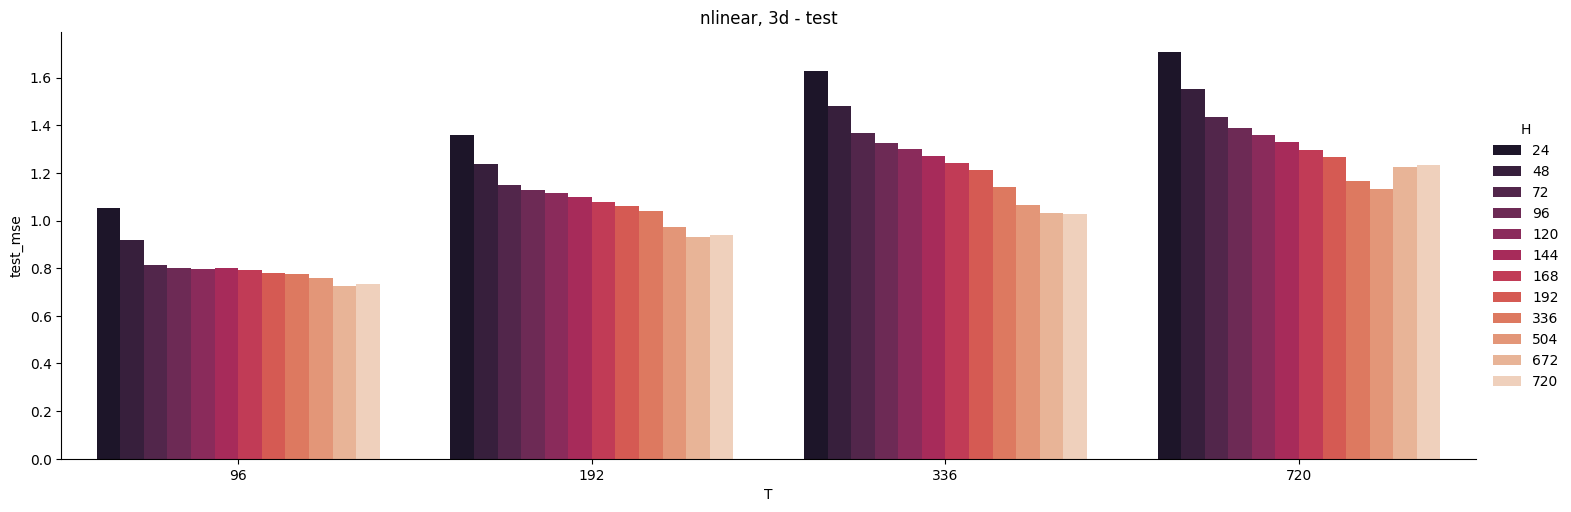

**************************************************


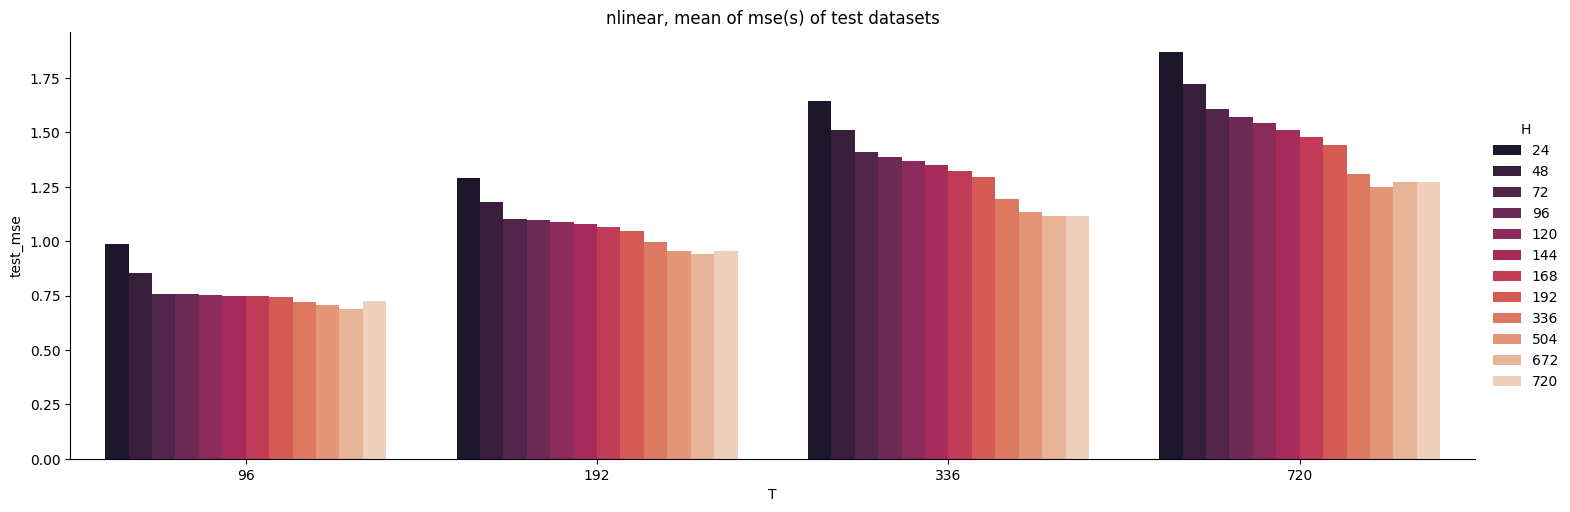

In [25]:
analyse(model='nlinear')

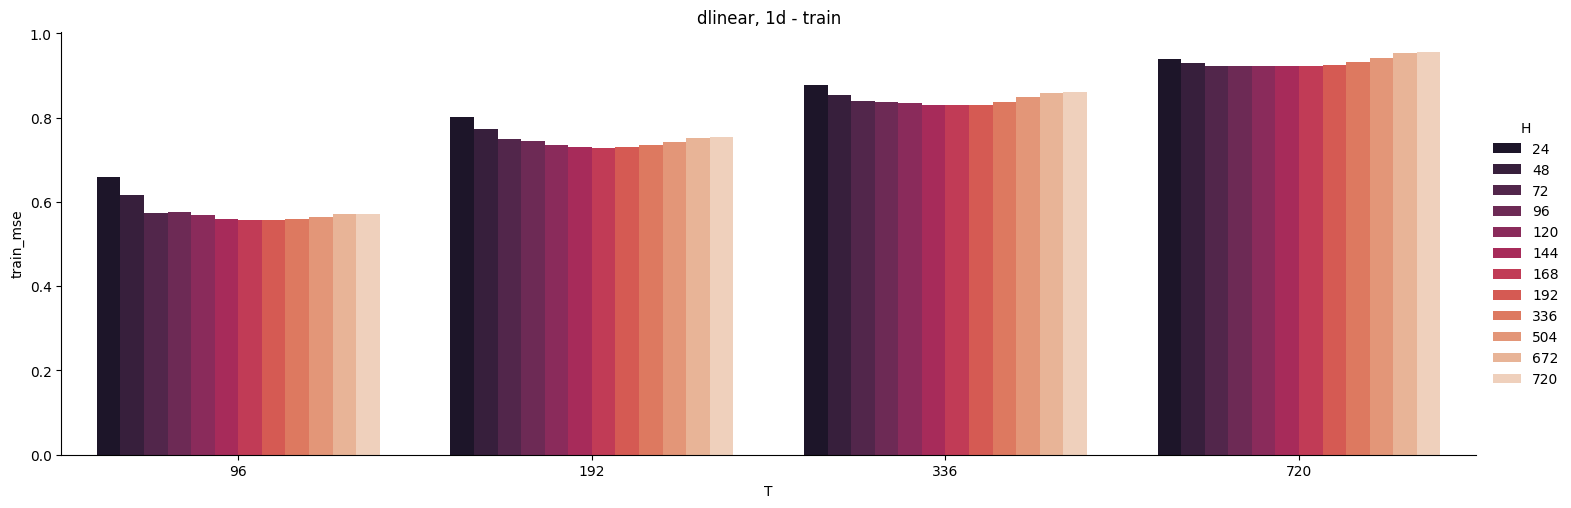

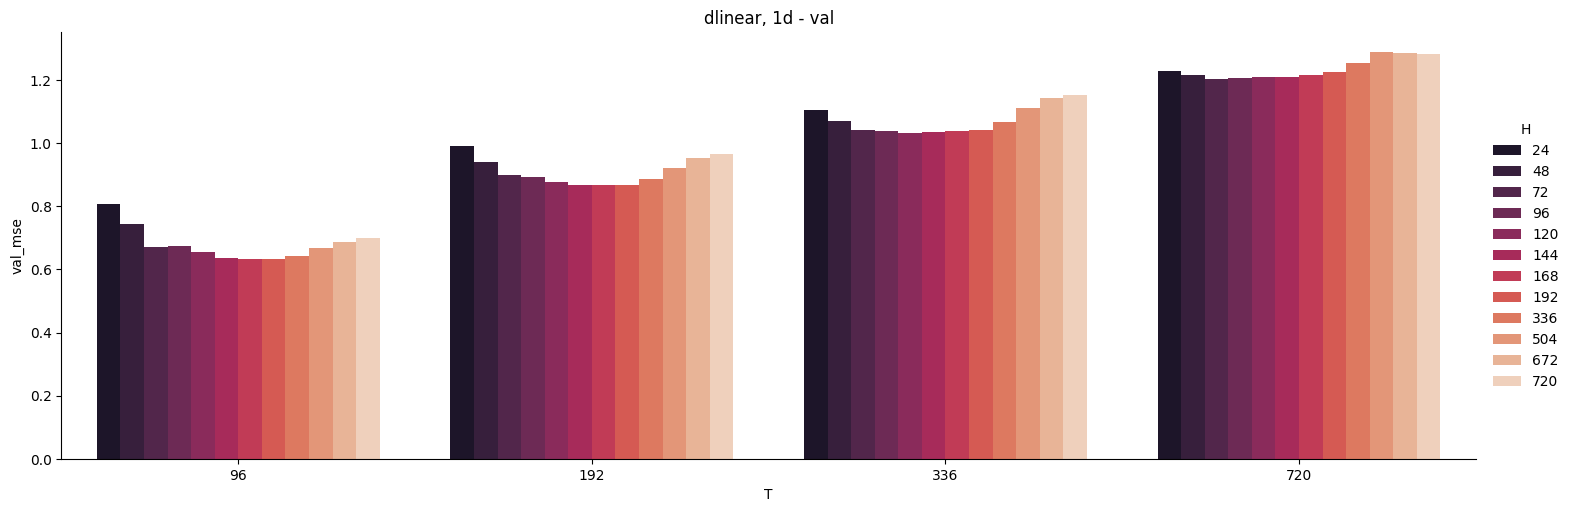

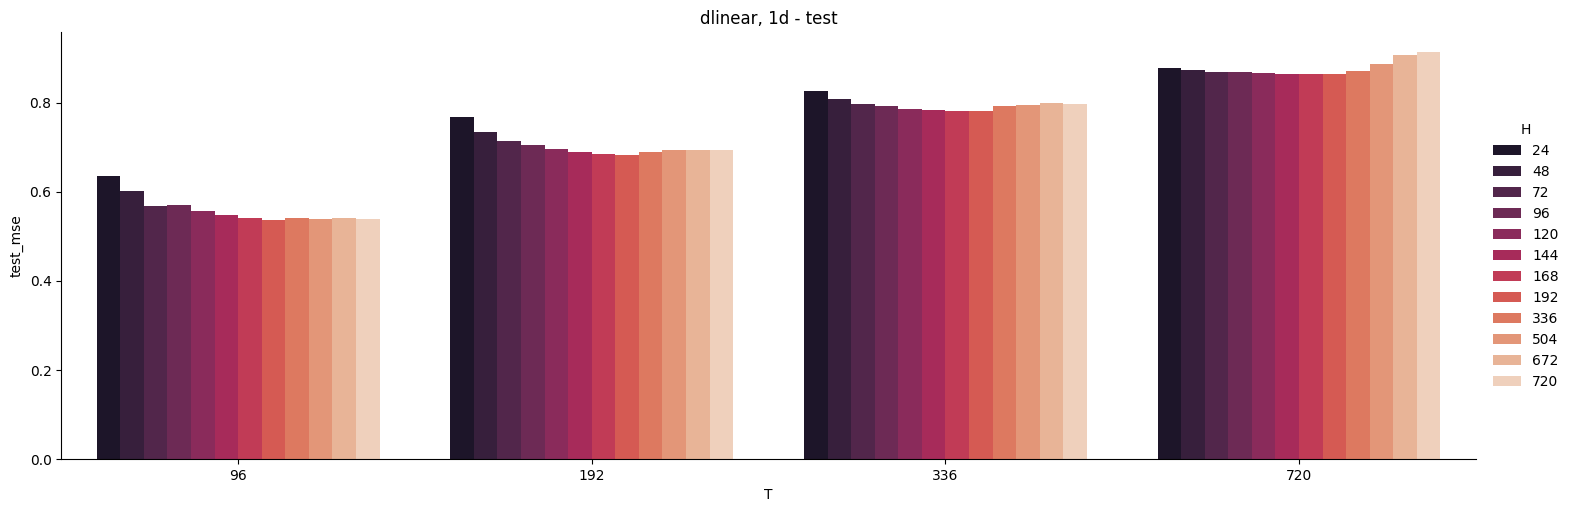

**************************************************


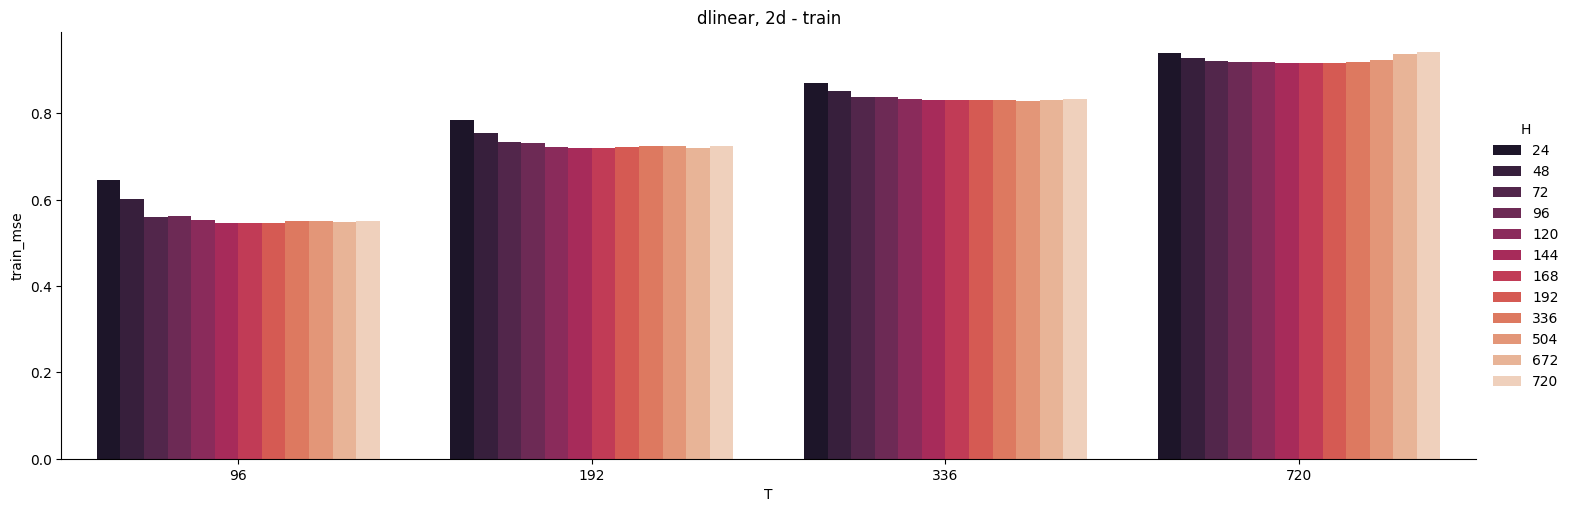

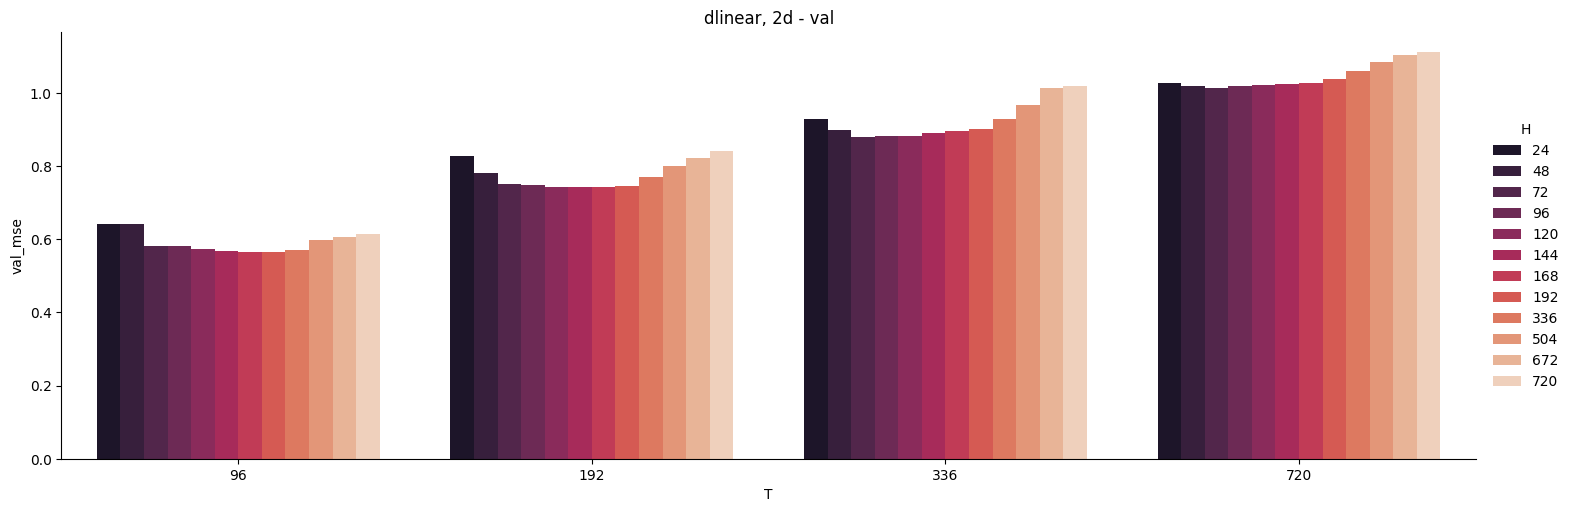

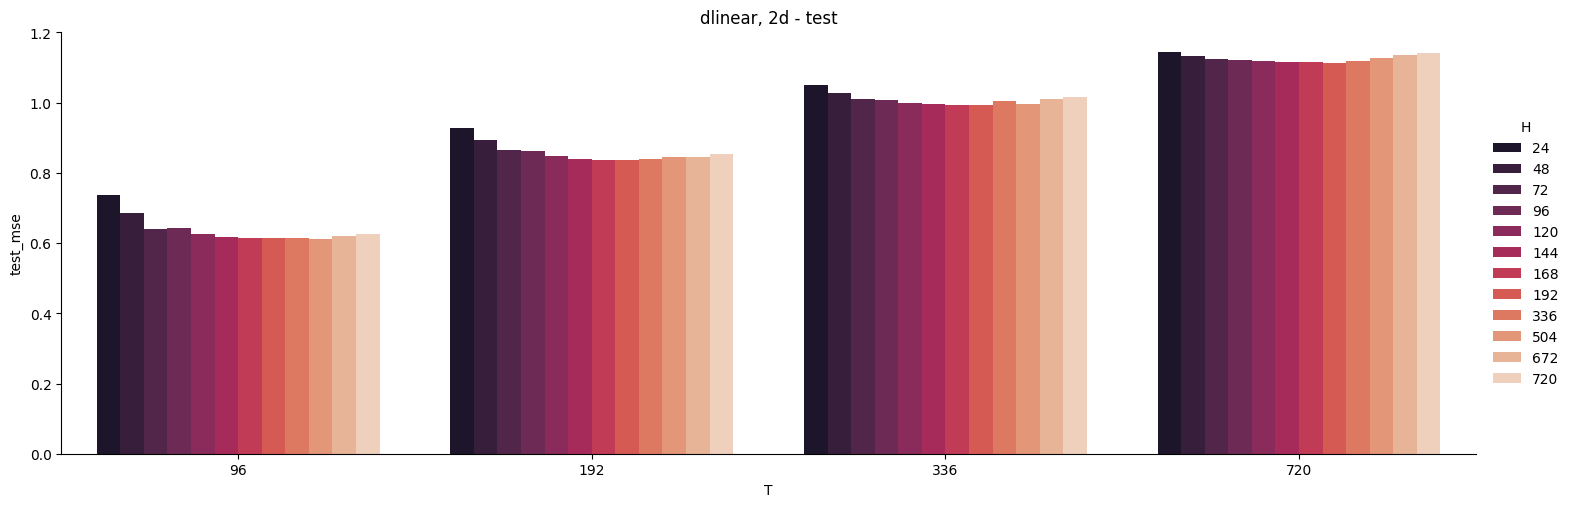

**************************************************


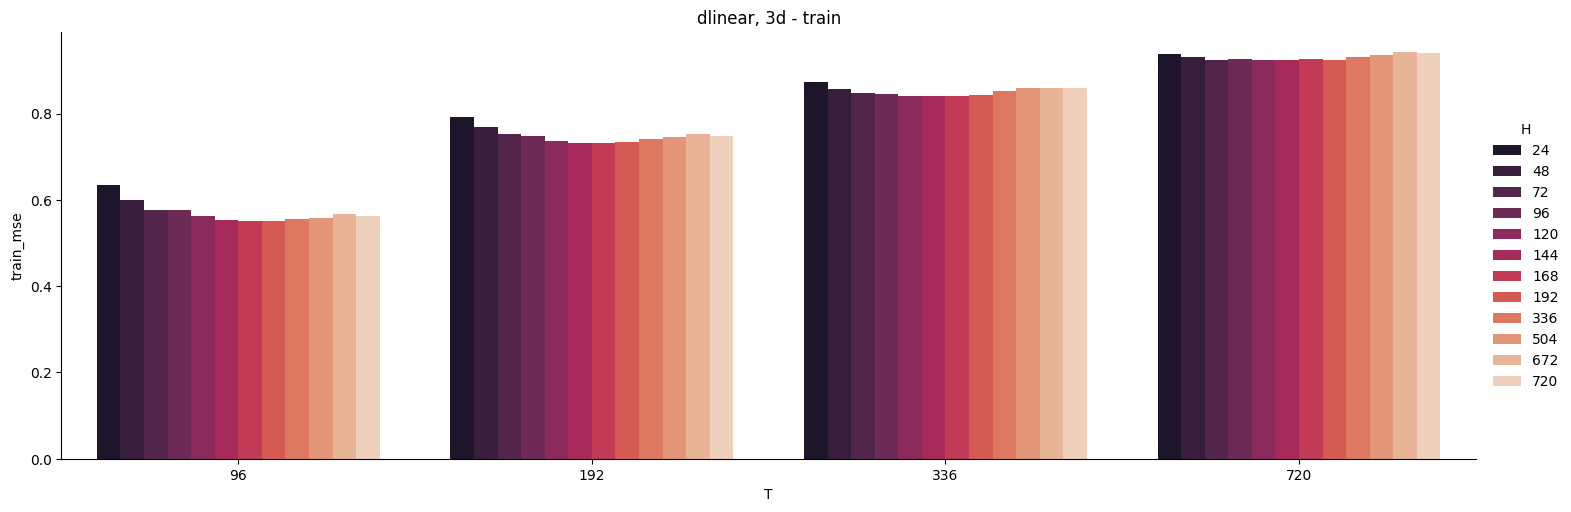

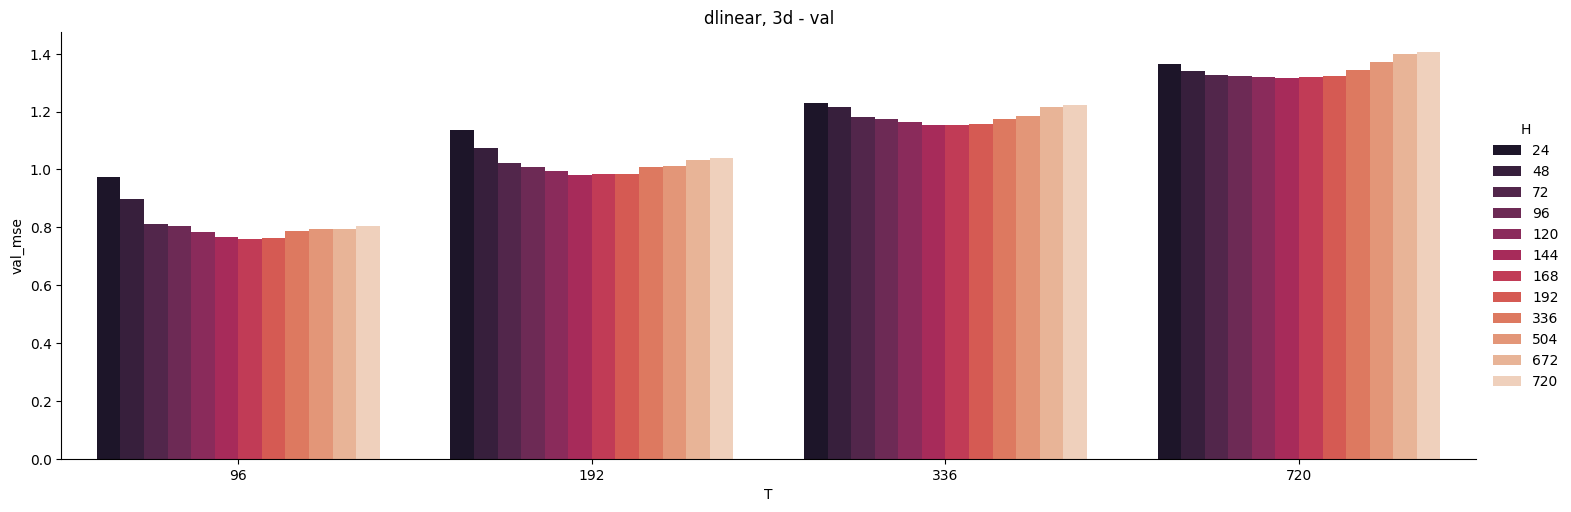

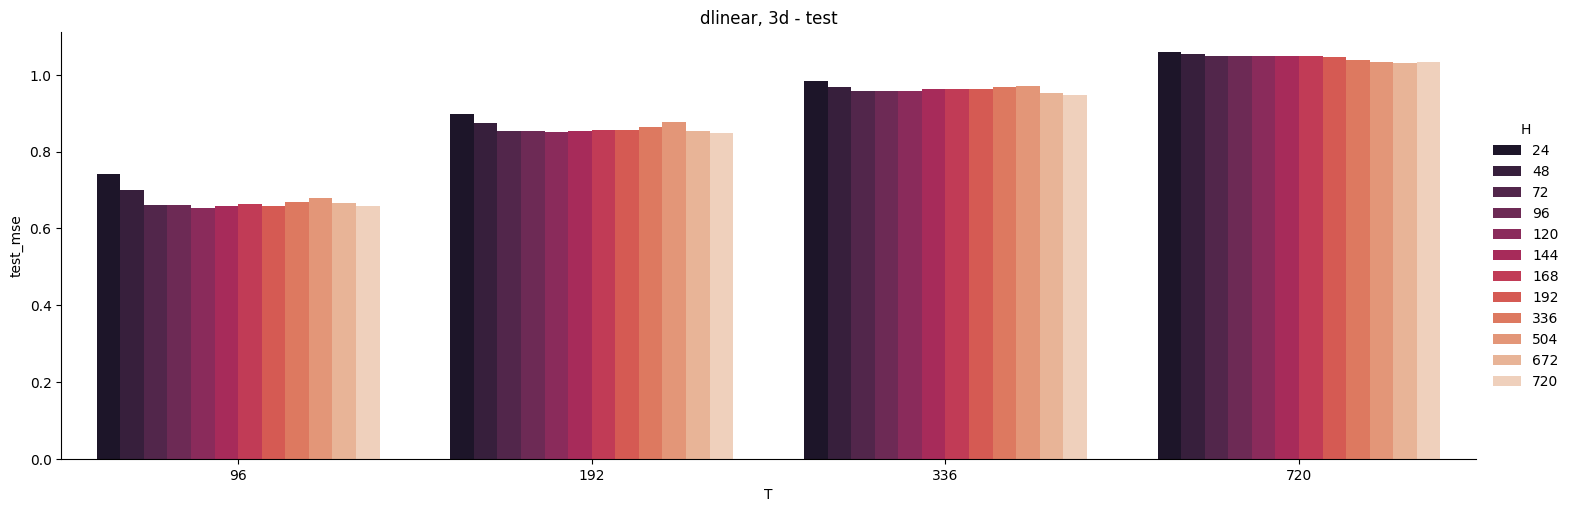

**************************************************


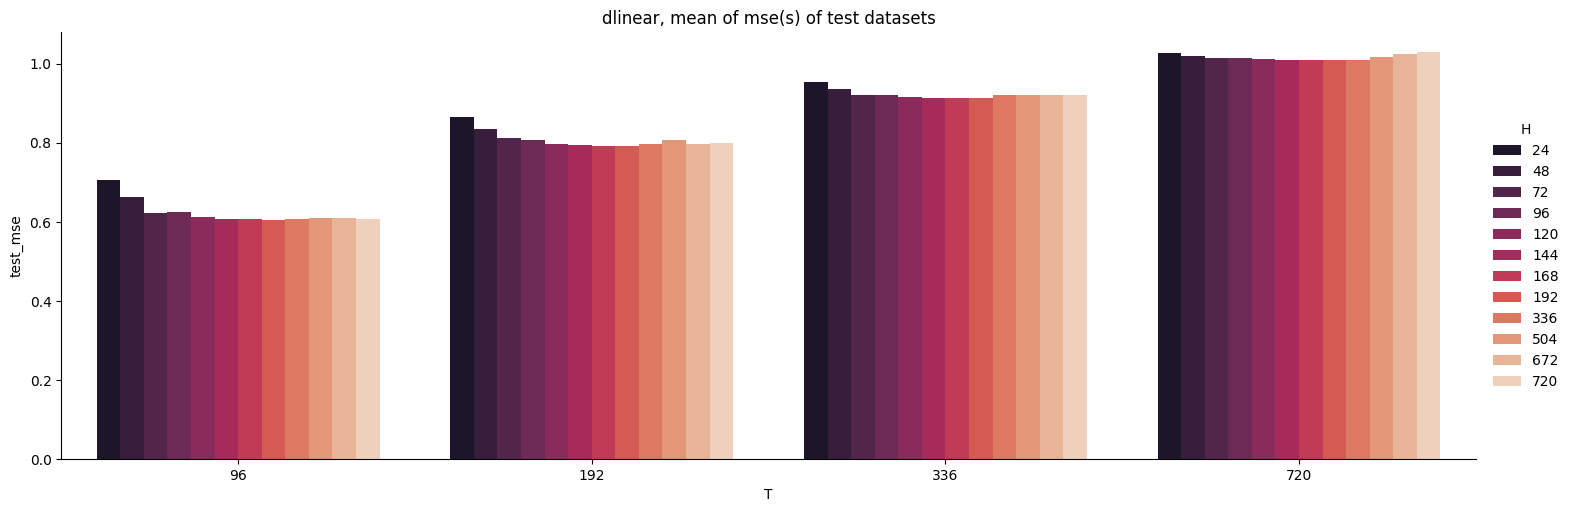

In [26]:
analyse(model = 'dlinear')